# About

Implement gradient descent algorithms to process the data directly. The results should align with MATLAB given the parameters are the same. For publishing, the MATLAB script and implementation should be primarily cited.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
from scipy import special
from scipy.spatial import distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
from tqdm.notebook import tqdm
import math
from math import pi


from lib import *

from IPython.display import clear_output

# Directories

In [2]:
foldername = os.path.join(os.getcwd(), 'data', 'matrices', 'ICBM')
filename_names = os.path.join(foldername, 'freesurfer_regions_68_sort_full.txt')
filename_pos = os.path.join(foldername, 'fs_region_centers_68_sort.txt')
filename_conn = os.path.join(foldername, 'icbm_fiber_mat.txt')

# Parameters

In [3]:
# Data import
W = np.loadtxt(fname = filename_conn) # Connections
pos = np.loadtxt(fname = filename_pos) # Positions of nodes

# Process imports
dist = distance.cdist(pos,pos,'euclidean')
W = W / np.max(W)
# W = np.minimum(100 * W / np.max(W), np.ones(W.shape)) # Normalize connectivity
# W = (W != 0).astype(float)
# W = special.erf(1000* W)
N = W.shape[0]

# Set parameters
vel0 = 1.0 # Initial velocity
tau0 = dist / vel0
r0 = 0.1*np.ones(N) # Baseline firing rate
kappa = 60**2 # How punishing non-coincident delays are (lower = more punishing). Note delays have std approx 30.
gamma0 = 1.0 # Normalization constant for coincidences

# Employ learning model

## Adaptive learning with gradual injury

### Set-up

In [4]:
# Learning parameters
eta = 200
numIters = 240

# Outputs
time = range(numIters)
objective = np.zeros(numIters)

# Objective function
objFun = FunLib.objectiveFun

# Stability:
stab = np.zeros(numIters)

# Injury parameters (w.r.t time/iters)
vel_range = [0.5, 2.0]
velInj = np.random.uniform(low=vel_range[0], high=vel_range[1], size=tau0.shape) # Conduction velocity across unmyelinated axons
beta = 0.05 # Rate of injury (Higher = faster exponential rate). May make this randomly sampled
injIndex = 0.1 # Percentage of injured axons (random). Perhaps make this regional? Set to 0 for no injury
injTime = 0.6 # When injury begins getting implemented as a fraction of total time (numIters)

isInj = (np.random.uniform(size=tau0.shape) < injIndex).astype('float64')

## Display parameters

In [5]:
# Table 1: Main parameters
var_name1 = ['N', r'Initial velocity $v_0$', 
            r'Scaling factor $\kappa$', 
            r'Myelination rate $\eta$', 
            r'Baseline firing rate $r_i^0$',
            r'Coincidence normalizer $\gamma$']

var_value1 = [N, vel0, kappa, eta, r0[0], gamma0]

var_name1 = np.array(var_name1)
var_value1 = np.array(var_value1)

table1 = pd.DataFrame({'Variable' : var_name1, 'Value': var_value1})

# Table 2: Injury parameters
var_name2 = [r'Total iterations',
             r'$v_0$ uniform sample range',
             r'Rate of injury $\beta$',
             r'Injury index',
             r'Injury time']
var_value2 = [numIters, vel_range, beta, injIndex, injTime*numIters]

table2 = pd.DataFrame({'Variable' : var_name2, 'Value': var_value2})

### Table 1

In [6]:
table1.style

,Variable,Value
0,N,68
1,Initial velocity $v_0$,1
2,Scaling factor $\kappa$,3600
3,Myelination rate $\eta$,200
4,Baseline firing rate $r_i^0$,0.1
5,Coincidence normalizer $\gamma$,1


In [7]:
table2.style

,Variable,Value
0,Total iterations,240
1,$v_0$ uniform sample range,"[0.5, 2.0]"
2,Rate of injury $\beta$,0.05
3,Injury index,0.1
4,Injury time,144


### Set up arrays to plot

In [8]:
# Sample sizes
numTauInj = min(100, int(injIndex * N**2))
numTauNonInj = min(100, int((1-injIndex) * N**2))

# Sample indices to be plotted
injInds = np.where((isInj == 1) * (W != 0))
nonInjInds = np.where((isInj == 0) * (W != 0))

injSample = np.random.choice(injInds[0].size, numTauInj)
nonInjSample = np.random.choice(nonInjInds[0].size, numTauNonInj)

injInds_i = injInds[0][injSample]
injInds_j = injInds[1][injSample]
nonInjInds_i = nonInjInds[0][nonInjSample]
nonInjInds_j = nonInjInds[1][nonInjSample]

### Implement learning rule over time

In [9]:
# Initialize
r_i = r0
tau = tau0
tauInj = dist / velInj

tauInj_arr = np.zeros((numIters, numTauInj),dtype='float64')
tauNonInj_arr = np.zeros((numIters, numTauInj),dtype='float64')
velInj_arr = np.zeros((numIters, numTauInj),dtype='float64')
velNonInj_arr = np.zeros((numIters, numTauInj),dtype='float64')

dist_inj = np.reshape(dist[injInds_i, injInds_j], -1)
dist_nonInj = np.reshape(dist[nonInjInds_i, injInds_j], -1)

# MAIN LOOP
for i in tqdm(time):
    
    # Determine the equilibrium solution using current delays
    gamma = gamma0 * FunLib.coincidenceFactorGauss(kappa, W, tau)
    r_i = np.linalg.solve(np.identity(N) - W*gamma/N, r0) # Use instead of inversion
    
    # Store objective function
    objective[i] = objFun(r_i)
    
    # Stability
    eigs = np.linalg.eig(W*gamma/N - np.eye(N))
    stab[i] = np.max(np.real(eigs[0]))
    
    # Gradient
    gradObj = np.zeros(tau.shape)
    for j in range(gradObj.shape[0]):
        for k in range(gradObj.shape[1]):
            if W[j,k] != 0:
                gradObj_jk = FunLib.derivLearningRateSlow(W, tau, kappa, gamma0, gamma, r_i, (j,k))
                gradObj[j,k] = gradObj_jk
                # if np.random.uniform() < 0.05:
                    # print(np.mean(gradObj_jk[1]))
                
                
    # for k in range(gradObj.shape[0]):
        # gradObj[k,:] = FunLib.derivLearningRate(W, tau, kappa, gamma0, gamma, r_i, k)
    
    # Modify delays
    if i < injTime * numIters:
        tau = tau + eta * gradObj
        tau = tau * (tau > 0) # Ensure tau is 0
    
    else:
        # tau = tau - (1-isInj)*eta*kappa*r_i[:,np.newaxis]*r_i*W*gamma*FunLib.sumDiffs(W, tau)/N - isInj*beta*(tau - tauInj)
        tau = tau + eta * (1-isInj) * gradObj - isInj*beta*(tau - tauInj)
        tau = tau * (tau > 0) # Ensure tau is 0
         
    # Record sampled delays over time
    tauInj_arr[i,:] = np.reshape(tau[injInds_i, injInds_j], -1)
    tauNonInj_arr[i,:] = np.reshape(tau[nonInjInds_i, nonInjInds_j], -1)
    velInj_arr[i,:] = dist_inj / tauInj_arr[i,:]
    velNonInj_arr[i,:] = dist_nonInj / tauNonInj_arr[i,:]

  0%|          | 0/240 [00:00<?, ?it/s]

# Figures

## Objective function

(0, 240)

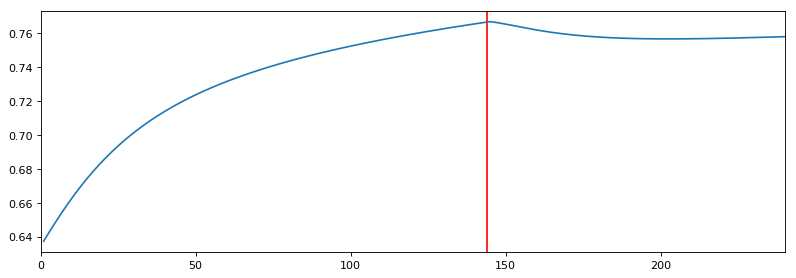

In [10]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(1,numIters+1)
ax.plot(iters, objective)
ax.axvline(injTime * numIters, color='red', zorder=0)
ax.set_xlim(left=0, right=numIters)

## Plots of conduction velocities and delays of injured, uninjured axons over time

### Set up arrays to plot

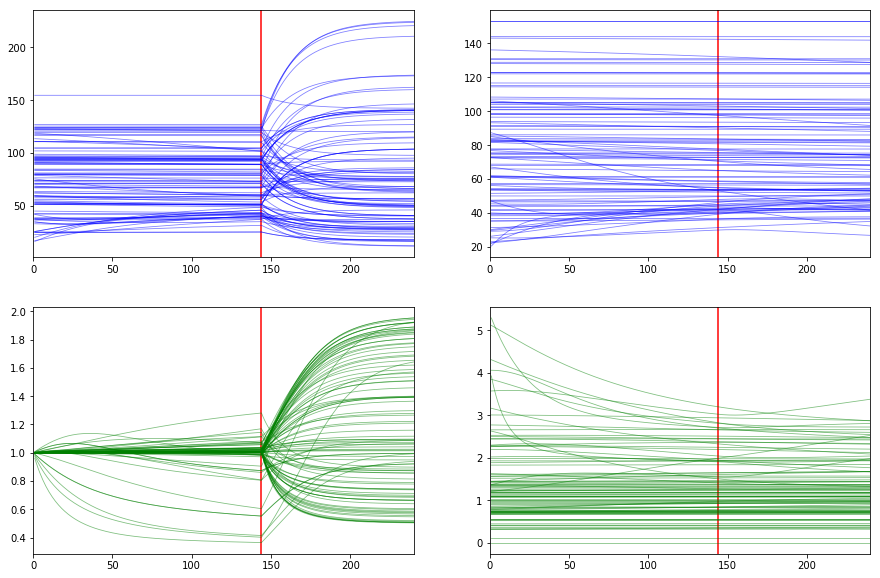

In [11]:
# Options
lw1 = 0.8
alp1 = 0.5

fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0][0].plot(iters, tauInj_arr, linewidth=lw1, alpha=alp1, color='blue')
axs[1][0].plot(iters, velInj_arr, linewidth=lw1, alpha=alp1, color='green')
axs[0][1].plot(iters, tauNonInj_arr, linewidth=lw1, alpha=alp1, color='blue')
axs[1][1].plot(iters, velNonInj_arr, linewidth=lw1, alpha=alp1, color='green')

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i][j].set_xlim(left=0, right=numIters)
        axs[i][j].axvline(injTime * numIters, color='red', zorder=0)

## Connectivity and initial delay matrices

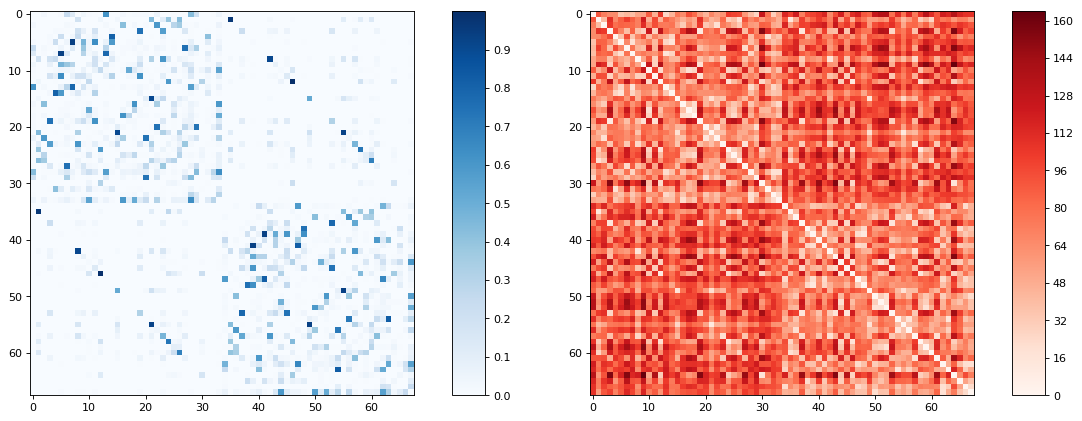

In [12]:
# Positions [left, bottom, width, height] 
bbox0 = [0.05, 0.1, 0.35, 0.80]
bbox1 = [0.43, 0.1, 0.03, 0.80]
bbox2 = [0.55, 0.1, 0.35, 0.80]
bbox3 = [0.93, 0.1, 0.03, 0.80]

fig, ax = plt.subplots(4, figsize=(14,6), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

cs1 = ax[0].imshow(W, cmap='Blues')
cs2 = ax[2].imshow(tau0, cmap='Reds')

# Colour bars
numticks1 = 10
numticks2 = 10
ticks1 = np.arange(0, np.max(W), np.round(np.max(W) / numticks1, decimals=1)) # Connectivity strength
ticks2 = np.arange(0, np.max(tau0), np.round(np.max(tau0) / numticks2, decimals=0)) # Delays

fig.colorbar(cs1, cax=ax[1], ticks=ticks1)
fig.colorbar(cs2, cax=ax[3], ticks=ticks2)

### Statistics

In [13]:
num_conns = np.count_nonzero(W != 0.0)
print(f'Number of active connections: {num_conns} out of {W.size}')

Number of active connections: 3726 out of 4624


In [14]:
np.max(gradObj), np.mean(W), np.mean(gamma)

(0.007425731246276244, 0.03925114746600026, 0.7947907472844901)

In [15]:
s = np.linalg.norm(W)
t = np.max(W)
s, t
np.mean(W[W != 0]), np.mean(W)

(0.04871103217466055, 0.03925114746600026)

In [16]:
stab

array([-0.67112791, -0.66749817, -0.66399714, -0.66063433, -0.65741662,
       -0.65434837, -0.65143156, -0.64866611, -0.64605012, -0.64358016,
       -0.64125165, -0.63905907, -0.63699628, -0.63505669, -0.63323352,
       -0.63151992, -0.62990907, -0.62839436, -0.62696937, -0.62562798,
       -0.62436435, -0.62317302, -0.62204883, -0.62098695, -0.61998292,
       -0.61903256, -0.618132  , -0.61727768, -0.61646629, -0.61569478,
       -0.61496035, -0.61426039, -0.61359252, -0.61295454, -0.61234443,
       -0.61176032, -0.61120048, -0.61066334, -0.61014743, -0.6096514 ,
       -0.60917402, -0.60871414, -0.6082707 , -0.60784273, -0.60742931,
       -0.60702961, -0.60664286, -0.60626834, -0.60590539, -0.60555338,
       -0.60521175, -0.60487996, -0.60455752, -0.60424397, -0.60393886,
       -0.60364181, -0.60335244, -0.60307039, -0.60279534, -0.60252697,
       -0.60226502, -0.60200919, -0.60175923, -0.60151492, -0.60127601,
       -0.60104231, -0.6008136 , -0.6005897 , -0.60037042, -0.60

In [17]:
objective

array([0.63724369, 0.6402409 , 0.64319748, 0.64610828, 0.64896877,
       0.65177508, 0.65452401, 0.65721302, 0.65984019, 0.66240416,
       0.66490413, 0.66733974, 0.66971104, 0.67201842, 0.67426258,
       0.67644443, 0.67856508, 0.6806258 , 0.68262798, 0.68457307,
       0.6864626 , 0.68829816, 0.69008133, 0.69181371, 0.69349691,
       0.69513253, 0.69672212, 0.69826725, 0.69976943, 0.70123014,
       0.70265083, 0.70403291, 0.70537776, 0.70668671, 0.70796104,
       0.709202  , 0.7104108 , 0.71158859, 0.71273652, 0.71385564,
       0.71494702, 0.71601165, 0.7170505 , 0.7180645 , 0.71905455,
       0.7200215 , 0.72096617, 0.72188937, 0.72279184, 0.72367433,
       0.72453754, 0.72538213, 0.72620876, 0.72701805, 0.72781059,
       0.72858695, 0.72934769, 0.73009333, 0.73082437, 0.73154131,
       0.73224461, 0.73293471, 0.73361206, 0.73427705, 0.73493009,
       0.73557155, 0.73620182, 0.73682122, 0.73743012, 0.73802882,
       0.73861765, 0.7391969 , 0.73976686, 0.74032781, 0.74088

In [18]:
np.mean(gamma)

0.7947907472844901